In [2]:
import numpy as np
from sklearn.model_selection import train_test_split        #split data for training and testing
from sklearn.metrics import accuracy_score                  #to view accuracy
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops      #for math operations division_no_nan
from tensorflow.keras.layers import *
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.metrics import roc_curve, auc
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

from qkeras import *
import hls4ml
from hls4ml.model.profiling import numerical, activations_keras, boxplot

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 16.0

seed = 48

np.random.seed(seed)
tf.random.set_seed(seed)

import os
import sys

# will need to clone https://github.com/kpidgeon/cms-l1-triggers for a few
# helper functions if running notebook and include path to repo here
sys.path.append('/usersc/bz18310/previous_notebook/cms-l1-triggers')

from utils.analysis import eff_rate, optimal_eff_rate
from utils.preprocessing import resize
from utils.plotting import *
from utils.hls4ml_helpers import *

plt.rc('figure', figsize=(8,6))

In [3]:
# a couple of helper functions

push = lambda x: x > .5       #function to check if number greater than .5

def hls_model_accuracy(hls_model, test_X, test_y):                              #function for testing accurcry of hls model
    return accuracy_score(test_y, [push(i) for i in hls_model.predict(test_X)])


def get_timing(build_result):
    return (build_result['BestLatency'], build_result['WorstLatency'],
            build_result['IntervalMin'], build_result['IntervalMax'])

class CustomSensitivityAtSpecificity(tf.keras.metrics.SensitivityAtSpecificity):     #specificity TN/(TN+FP) 
                                                                                
    def __init__(self, specificity, num_thresholds=200, name=None, dtype=None):
        if specificity < 0 or specificity > 1:
            raise ValueError('`specificity` must be in the range [0, 1].')
        self.specificity = specificity
        self.num_thresholds = num_thresholds
        super().__init__(
            specificity, num_thresholds=num_thresholds, name=name, dtype=dtype)  #from the tf.kera.metrics.SensitivityAtSpecificity
                                                                                 #class, creates out object
    def result(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)   #from keras class super()
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)   
        return self._find_max_under_constraint(
                    specificities, sensitivities, math_ops.greater_equal)  #What?

    def get_threshold(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)
        
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)    #Sensitivity TP/(TP+FN)
        
        specs_above_thresh = array_ops.where(math_ops.greater_equal(specificities, self.value))   #What?
        
        return math_ops.reduce_min(array_ops.gather(self.thresholds, specs_above_thresh)).numpy()
        
    
    def get_config(self):
        config = {
            'num_thresholds': self.num_thresholds,
            'specificity': self.specificity
        }
        base_config = super().get_config()    #from keras class object.
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
from numpy import load

data = load('./data_hh4b_20x12_160000.npz')


In [5]:
### Load the Keras model and the training/test data

data = np.load('./data_hh4b_20x12_160000.npz')
train_X = data['train_X']      #data for training the quantized model
train_y = data['train_y']      #data labels
test_X = data['test_X']
test_y = data['test_y']
test_X_hw_hh4b = data['test_X_hw_hh4b']
test_y_hw_hh4b = data['test_y_hw_hh4b']
test_X_hw_snu = data['test_X_hw_snu']
test_y_hw_snu = data['test_y_hw_snu']
data = 0

print(np.shape(train_X))
print(np.shape(train_y))

model = tf.keras.models.load_model('./cnn_20x12_keras_trained')   #load trained model

model.summary()
model.optimizer     #adam optimizer



(120000, 20, 12, 1)
(120000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 18, 10, 4)         36        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 5, 4)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 5, 4)           16        
_________________________________________________________________
relu_c1 (Activation)         (None, 9, 5, 4)           0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 3, 8)           288       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
batch_normalization_1 (Bat

In [6]:
### Quantize the model using 16 fractional bits

b = 16
config = {

        'QConv2D': {
          "kernel_quantizer": f'quantized_bits({b})',
          "bias_quantizer": f'quantized_bits({b})'
        },
        'QDense': {
          "kernel_quantizer": f'quantized_bits({b})',
          "bias_quantizer": f'quantized_bits({b})'
        },
        'QActivation': {'relu': f'quantized_relu({b})'}

    }

qmodel = utils.model_quantize(model, config, 16)        #configure model from struccture we saved.
qmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (QConv2D)              (None, 18, 10, 4)         36        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 5, 4)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 5, 4)           16        
_________________________________________________________________
relu_c1 (QActivation)        (None, 9, 5, 4)           0         
_________________________________________________________________
conv2 (QConv2D)              (None, 7, 3, 8)           288       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1, 8)           3

In [6]:
opt = tf.keras.optimizers.Adam(0.001)     #adam optimizer selected
sensitivity_metric = tf.keras.metrics.SensitivityAtSpecificity(name='sens_at_spec',
                                                                         specificity=0.99925,     
                                                                         num_thresholds=20000)     #What?
auc_metric = tf.keras.metrics.AUC(name='auc', num_thresholds=200)   #gets AUC curve?
metrics = ['accuracy', sensitivity_metric, auc_metric]
qmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)    #compiled quantized model here

In [7]:
qmodel.fit(train_X, 
           train_y, 
           epochs=50, 
           verbose=1,
           batch_size=512, 
           validation_split=.2,   #validation split here
           shuffle=True,
           callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=5,
                                                         restore_best_weights=True),     #What does callbacks do?
                        pruning_callbacks.UpdatePruningStep()])

Epoch 1/50
188/188 [==============================] - 25s 111ms/step - loss: 0.3759 - accuracy: 0.9227 - sens_at_spec: 0.0950 - auc: 0.9631 - val_loss: 0.7067 - val_accuracy: 0.5308 - val_sens_at_spec: 0.3662 - val_auc: 0.7024
Epoch 2/50
188/188 [==============================] - 18s 98ms/step - loss: 0.2938 - accuracy: 0.9632 - sens_at_spec: 0.1600 - auc: 0.9877 - val_loss: 0.5940 - val_accuracy: 0.6800 - val_sens_at_spec: 0.4141 - val_auc: 0.9166
Epoch 3/50
188/188 [==============================] - 18s 97ms/step - loss: 0.2575 - accuracy: 0.9662 - sens_at_spec: 0.1800 - auc: 0.9891 - val_loss: 0.2661 - val_accuracy: 0.9424 - val_sens_at_spec: 0.2575 - val_auc: 0.9890
Epoch 4/50
188/188 [==============================] - 18s 96ms/step - loss: 0.2293 - accuracy: 0.9679 - sens_at_spec: 0.1775 - auc: 0.9901 - val_loss: 0.2110 - val_accuracy: 0.9690 - val_sens_at_spec: 0.1364 - val_auc: 0.9912
Epoch 5/50
188/188 [==============================] - 19s 99ms/step - loss: 0.2065 - accuracy: 

(1, 1000)

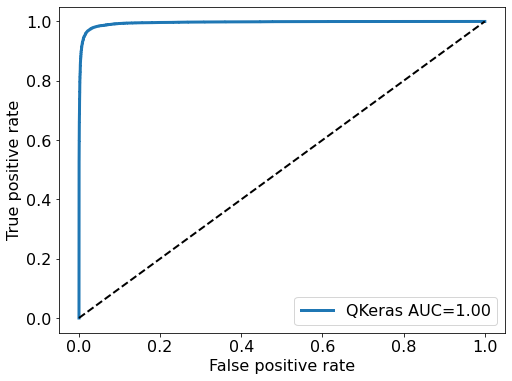

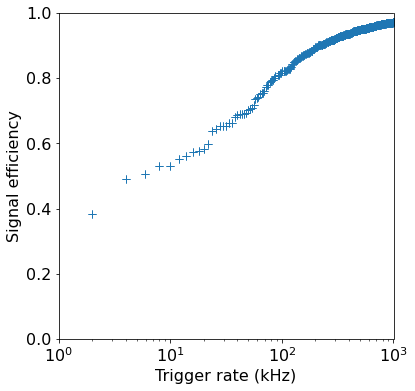

In [8]:
fpr, tpr, thresholds = roc_curve(test_y, qmodel.predict(test_X))  #get false positive rate, true pos rate and thresholds

fig, ax = plt.subplots()
plot_roc(ax, fpr, tpr, legend=True, label='QKeras', lw=3.)      #plots ROC curve
plt.plot([0,1], [0,1], ls='--', lw=2., color='black')           #

bg_rate = 40*10**6
rates, rates_errs, effs, effs_errs = eff_rate(fpr, tpr, thresholds, 
                                              bg_rate, 
                                              test_y, 
                                              qmodel.predict(test_X))

effs, rates, effs_errs, rates_errs = optimal_eff_rate(effs, rates, effs_errs, rates_errs)

fig, ax = plt.subplots(figsize=(6,6))               #Plots signal efficiency vs trigger rate.
plot_eff_rate(ax, np.array(effs), np.array(rates), 
              rates_errs=rates_errs, effs_errs=effs_errs, ls='', capsize=4.)
ax.set_xscale('log')
ax.set_xlim((1,1000))

In [9]:
### Train a selection of QKeras models and convert to HLS models

storage_area = './'       #storing our trained models

for b in range(4, 13):       #i.e. b = 4 and 5
    
    config = {

        'QConv2D': {
          "kernel_quantizer": f'quantized_bits({b}, 0, alpha=1)',         #What?, what is alpha and why the 0 here?
          "bias_quantizer": f'quantized_bits({b}, 0, alpha=1)'
        },
        'QDense': {
          "kernel_quantizer": f'quantized_bits({b}, 0, alpha=1)',
          "bias_quantizer": f'quantized_bits({b}, 0, alpha=1)'
        },
        'QActivation': {'relu': f'quantized_relu({b})'}

    }

    qmodel = utils.model_quantize(model, config, b)      #HLS model configured here
    opt = tf.keras.optimizers.Adam(0.001)               #with adam optimizer
    sensitivity_metric = tf.keras.metrics.SensitivityAtSpecificity(name='sens_at_spec',
                                                                             specificity=0.99925, 
                                                                             num_thresholds=2000)    #Find out this stuff for better comparison
    auc_metric = tf.keras.metrics.AUC(name='auc', num_thresholds=200)
    metrics = ['accuracy', sensitivity_metric, auc_metric]
    qmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)      #compile qmodel again
    
    qmodel.fit(train_X, 
               train_y, 
               epochs=50, 
               verbose=1,
               batch_size=512, 
               validation_split=.2, 
               shuffle=True,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=5,
                                                         restore_best_weights=True),
                        pruning_callbacks.UpdatePruningStep()])
    
    hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']      #What does this do?
    hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
    hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

    config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')   #hls4ml get config from kera config
    for l in config['LayerName']:
        config['LayerName'][l]['Strategy'] = 'Latency'
    config['LayerName']['sigmoid']['exp_table_t'] = 'ap_fixed<18,8>'
    config['LayerName']['sigmoid']['inv_table_t'] = 'ap_fixed<18,4>'
    
    hls_model = hls4ml.converters.convert_from_keras_model(qmodel,
                                                       hls_config=config,   #set configuration of model
                                                       output_dir=f'{storage_area}qat_<{b+1},1>/hls4ml_prj',  #6bit model save
                                                       fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                        clock_period=(1/.24),      #set clock period??
                                                          io_type='io_stream')     #What?
    hls_model.compile()   #compiles model
#     break
    

Epoch 1/50
188/188 [==============================] - 7s 26ms/step - loss: 0.3442 - accuracy: 0.9472 - sens_at_spec: 0.0876 - auc: 0.9811 - val_loss: 0.6942 - val_accuracy: 0.5366 - val_sens_at_spec: 0.4340 - val_auc: 0.8357
Epoch 2/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2838 - accuracy: 0.9655 - sens_at_spec: 0.1565 - auc: 0.9900 - val_loss: 0.4874 - val_accuracy: 0.7472 - val_sens_at_spec: 0.4363 - val_auc: 0.9857
Epoch 3/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2498 - accuracy: 0.9676 - sens_at_spec: 0.1891 - auc: 0.9912 - val_loss: 0.2627 - val_accuracy: 0.9555 - val_sens_at_spec: 0.3000 - val_auc: 0.9926
Epoch 4/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2230 - accuracy: 0.9693 - sens_at_spec: 0.1890 - auc: 0.9916 - val_loss: 0.2105 - val_accuracy: 0.9689 - val_sens_at_spec: 0.2402 - val_auc: 0.9933
Epoch 5/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2015 - accuracy: 0.9696

Epoch 14/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1147 - accuracy: 0.9725 - sens_at_spec: 0.3894 - auc: 0.9943 - val_loss: 0.1125 - val_accuracy: 0.9712 - val_sens_at_spec: 0.4684 - val_auc: 0.9946
Epoch 15/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1113 - accuracy: 0.9723 - sens_at_spec: 0.2989 - auc: 0.9939 - val_loss: 0.1149 - val_accuracy: 0.9683 - val_sens_at_spec: 0.3168 - val_auc: 0.9949
Epoch 16/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1068 - accuracy: 0.9727 - sens_at_spec: 0.3634 - auc: 0.9944 - val_loss: 0.1069 - val_accuracy: 0.9722 - val_sens_at_spec: 0.5337 - val_auc: 0.9951
Epoch 17/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1047 - accuracy: 0.9722 - sens_at_spec: 0.4472 - auc: 0.9943 - val_loss: 0.1036 - val_accuracy: 0.9709 - val_sens_at_spec: 0.4902 - val_auc: 0.9949
Epoch 18/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1009 - accuracy: 0

Done
Epoch 1/50
188/188 [==============================] - 7s 26ms/step - loss: 0.3690 - accuracy: 0.9292 - sens_at_spec: 0.0559 - auc: 0.9692 - val_loss: 0.6862 - val_accuracy: 0.5366 - val_sens_at_spec: 0.3972 - val_auc: 0.8847
Epoch 2/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2906 - accuracy: 0.9649 - sens_at_spec: 0.1458 - auc: 0.9902 - val_loss: 0.5032 - val_accuracy: 0.7757 - val_sens_at_spec: 0.5137 - val_auc: 0.9853
Epoch 3/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2554 - accuracy: 0.9677 - sens_at_spec: 0.1374 - auc: 0.9908 - val_loss: 0.2817 - val_accuracy: 0.9454 - val_sens_at_spec: 0.5169 - val_auc: 0.9927
Epoch 4/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2278 - accuracy: 0.9693 - sens_at_spec: 0.1174 - auc: 0.9912 - val_loss: 0.2077 - val_accuracy: 0.9689 - val_sens_at_spec: 0.2448 - val_auc: 0.9937
Epoch 5/50
188/188 [==============================] - 4s 21ms/step - loss: 0.2056 - accuracy: 0

Epoch 17/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1092 - accuracy: 0.9724 - sens_at_spec: 0.3363 - auc: 0.9943 - val_loss: 0.1076 - val_accuracy: 0.9715 - val_sens_at_spec: 0.3182 - val_auc: 0.9947
Epoch 18/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1047 - accuracy: 0.9734 - sens_at_spec: 0.4118 - auc: 0.9944 - val_loss: 0.1038 - val_accuracy: 0.9716 - val_sens_at_spec: 0.3749 - val_auc: 0.9949
Epoch 19/50
188/188 [==============================] - 4s 21ms/step - loss: 0.1026 - accuracy: 0.9728 - sens_at_spec: 0.3371 - auc: 0.9945 - val_loss: 0.1035 - val_accuracy: 0.9717 - val_sens_at_spec: 0.4689 - val_auc: 0.9948
Epoch 20/50
188/188 [==============================] - 4s 21ms/step - loss: 0.0997 - accuracy: 0.9728 - sens_at_spec: 0.4430 - auc: 0.9946 - val_loss: 0.1009 - val_accuracy: 0.9712 - val_sens_at_spec: 0.4941 - val_auc: 0.9951
Epoch 21/50
188/188 [==============================] - 4s 21ms/step - loss: 0.0973 - accuracy: 0

Done
Epoch 1/50
188/188 [==============================] - 5s 20ms/step - loss: 0.3792 - accuracy: 0.9210 - sens_at_spec: 0.0781 - auc: 0.9623 - val_loss: 0.6822 - val_accuracy: 0.5304 - val_sens_at_spec: 0.4773 - val_auc: 0.9348
Epoch 2/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2944 - accuracy: 0.9653 - sens_at_spec: 0.2006 - auc: 0.9891 - val_loss: 0.4624 - val_accuracy: 0.7835 - val_sens_at_spec: 0.4732 - val_auc: 0.9878
Epoch 3/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2581 - accuracy: 0.9674 - sens_at_spec: 0.1996 - auc: 0.9904 - val_loss: 0.2574 - val_accuracy: 0.9564 - val_sens_at_spec: 0.1816 - val_auc: 0.9923
Epoch 4/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2298 - accuracy: 0.9695 - sens_at_spec: 0.2094 - auc: 0.9911 - val_loss: 0.2123 - val_accuracy: 0.9695 - val_sens_at_spec: 0.1594 - val_auc: 0.9924
Epoch 5/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2070 - accuracy: 0

Epoch 20/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0965 - accuracy: 0.9727 - sens_at_spec: 0.4674 - auc: 0.9946 - val_loss: 0.0972 - val_accuracy: 0.9708 - val_sens_at_spec: 0.5367 - val_auc: 0.9949
Epoch 21/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0941 - accuracy: 0.9733 - sens_at_spec: 0.4981 - auc: 0.9947 - val_loss: 0.0947 - val_accuracy: 0.9705 - val_sens_at_spec: 0.5277 - val_auc: 0.9949
Epoch 22/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0927 - accuracy: 0.9729 - sens_at_spec: 0.4734 - auc: 0.9947 - val_loss: 0.0941 - val_accuracy: 0.9707 - val_sens_at_spec: 0.5932 - val_auc: 0.9951
Epoch 23/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0912 - accuracy: 0.9730 - sens_at_spec: 0.4968 - auc: 0.9948 - val_loss: 0.0918 - val_accuracy: 0.9710 - val_sens_at_spec: 0.5311 - val_auc: 0.9952
Epoch 24/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0897 - accuracy: 0

Done
Epoch 1/50
188/188 [==============================] - 5s 18ms/step - loss: 0.3361 - accuracy: 0.9547 - sens_at_spec: 0.1348 - auc: 0.9852 - val_loss: 0.6912 - val_accuracy: 0.5394 - val_sens_at_spec: 0.4450 - val_auc: 0.9790
Epoch 2/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2805 - accuracy: 0.9681 - sens_at_spec: 0.1696 - auc: 0.9903 - val_loss: 0.4075 - val_accuracy: 0.8384 - val_sens_at_spec: 0.4443 - val_auc: 0.9941
Epoch 3/50
188/188 [==============================] - 3s 16ms/step - loss: 0.2461 - accuracy: 0.9702 - sens_at_spec: 0.1821 - auc: 0.9912 - val_loss: 0.2440 - val_accuracy: 0.9664 - val_sens_at_spec: 0.4212 - val_auc: 0.9946
Epoch 4/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2203 - accuracy: 0.9709 - sens_at_spec: 0.1335 - auc: 0.9916 - val_loss: 0.2066 - val_accuracy: 0.9711 - val_sens_at_spec: 0.3354 - val_auc: 0.9936
Epoch 5/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1994 - accuracy: 0

Epoch 17/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1050 - accuracy: 0.9728 - sens_at_spec: 0.3548 - auc: 0.9942 - val_loss: 0.1028 - val_accuracy: 0.9719 - val_sens_at_spec: 0.3549 - val_auc: 0.9947
Epoch 18/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1011 - accuracy: 0.9731 - sens_at_spec: 0.3945 - auc: 0.9945 - val_loss: 0.1010 - val_accuracy: 0.9721 - val_sens_at_spec: 0.5075 - val_auc: 0.9949
Epoch 19/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0991 - accuracy: 0.9730 - sens_at_spec: 0.3956 - auc: 0.9945 - val_loss: 0.1004 - val_accuracy: 0.9720 - val_sens_at_spec: 0.4964 - val_auc: 0.9949
Epoch 20/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0965 - accuracy: 0.9730 - sens_at_spec: 0.5149 - auc: 0.9947 - val_loss: 0.0970 - val_accuracy: 0.9723 - val_sens_at_spec: 0.4992 - val_auc: 0.9950
Epoch 21/50
188/188 [==============================] - 3s 15ms/step - loss: 0.0943 - accuracy: 0

Epoch 2/50
188/188 [==============================] - 3s 14ms/step - loss: 0.2813 - accuracy: 0.9666 - sens_at_spec: 0.1892 - auc: 0.9903 - val_loss: 0.4484 - val_accuracy: 0.7925 - val_sens_at_spec: 0.4814 - val_auc: 0.9891
Epoch 3/50
188/188 [==============================] - 3s 14ms/step - loss: 0.2473 - accuracy: 0.9694 - sens_at_spec: 0.2107 - auc: 0.9913 - val_loss: 0.2367 - val_accuracy: 0.9622 - val_sens_at_spec: 0.4249 - val_auc: 0.9943
Epoch 4/50
188/188 [==============================] - 3s 15ms/step - loss: 0.2209 - accuracy: 0.9704 - sens_at_spec: 0.1674 - auc: 0.9918 - val_loss: 0.2036 - val_accuracy: 0.9700 - val_sens_at_spec: 0.2965 - val_auc: 0.9935
Epoch 5/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1997 - accuracy: 0.9708 - sens_at_spec: 0.2011 - auc: 0.9923 - val_loss: 0.1834 - val_accuracy: 0.9705 - val_sens_at_spec: 0.2635 - val_auc: 0.9938
Epoch 6/50
188/188 [==============================] - 3s 15ms/step - loss: 0.1826 - accuracy: 0.9712

In [10]:
### Check the performance of these models by evaluating the signal efficiency (sensitivity) at several reference fake rates

bitwidth_scan = pd.DataFrame({'bitwidth': [],
                              'sens_at_spec_10kHz': [],
                              'sens_at_spec_30kHz': [],
                              'sens_at_spec_50kHz': [],
                              'threshold_10kHz': [],
                             'threshold_30kHz': [],
                             'threshold_50kHz': []})

for dir in os.listdir(storage_area):

    m = re.match('^qat_<(\d+),1>', dir)    #get that qat file??? 
    if m:
        
        prj_dir = os.path.join(storage_area, dir, 'hls4ml_prj')  #project stored in qat<> file
        print('Loading QKeras model from', prj_dir)
        
        # putting this in as sometimes hls4ml seems to ignore it if only executed once..?
        hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
        hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
        hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
        
        # load hls model
        hls_model = load_qkeras_hls_model(prj_dir)  
        
        hls_model.compile()   #compile model
        
#         sens_at_spec = tf.keras.metrics.SensitivityAtSpecificity(0.99925, num_thresholds=25000)
        sens_at_spec_30 = CustomSensitivityAtSpecificity(0.99925, num_thresholds=2000)   #use this sensitivity class for the hls models
        sens_at_spec_50 = CustomSensitivityAtSpecificity(0.99875, num_thresholds=2000)
        sens_at_spec_10 = CustomSensitivityAtSpecificity(0.99975, num_thresholds=2000)
        
        sens_at_spec_10.update_state(test_y, hls_model.predict(test_X))   #update_state must be in super i guess.
        sens_at_spec_30.update_state(test_y, hls_model.predict(test_X))
        sens_at_spec_50.update_state(test_y, hls_model.predict(test_X))

        bitwidth_scan = bitwidth_scan.append({'bitwidth': int(m[1]), #'acc': hls_model_accuracy(hls_model, test_X, test_y),
                                               'sens_at_spec_10kHz': sens_at_spec_10.result().numpy(), #from class functions
                                              'sens_at_spec_30kHz': sens_at_spec_30.result().numpy(),
                                              'sens_at_spec_50kHz': sens_at_spec_50.result().numpy(),
                                            'threshold_10kHz': sens_at_spec_10.get_threshold(),
                                              'threshold_30kHz': sens_at_spec_30.get_threshold(),
                                              'threshold_50kHz': sens_at_spec_50.get_threshold(),
                                                  'device': 'fpga'
                                             },
                                             ignore_index=True)

bitwidth_scan

Loading QKeras model from ./qat_<11,1>/hls4ml_prj
Loading configuration from ./qat_<11,1>/hls4ml_prj/hls4ml_config.yml
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: QDense, cur

Done
Loading QKeras model from ./qat_<12,1>/hls4ml_prj
Loading configuration from ./qat_<12,1>/hls4ml_prj/hls4ml_config.yml
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: QDense

,bitwidth,sens_at_spec_10kHz,sens_at_spec_30kHz,sens_at_spec_50kHz,threshold_10kHz,threshold_30kHz,threshold_50kHz,device
0,11.0,0.207768,0.514772,0.651995,0.995498,0.992496,0.989495,fpga
1,7.0,0.382022,0.500000,0.589589,0.875438,0.776388,0.650825,fpga
2,6.0,0.411617,0.553160,0.621948,0.877439,0.790395,0.733867,fpga
3,5.0,0.575470,0.672194,0.726007,0.993497,0.989495,0.984492,fpga
4,13.0,0.237162,0.513416,0.593006,0.861431,0.577289,0.484742,fpga
5,8.0,0.291378,0.384082,0.478897,0.681841,0.585293,0.488744,fpga
6,12.0,0.338860,0.617827,0.706763,0.987494,0.970985,0.953477,fpga
7,9.0,0.472968,0.581952,0.681891,0.922961,0.859430,0.755378,fpga
8,10.0,0.393076,0.595719,0.751382,0.996498,0.992496,0.977989,fpga


In [11]:
### Let's do that for the CPU QKeras performance too for comparison

# bitwidth_scan_cpu = pd.DataFrame({'bitwidth': [],                  #guess we can just overwrite our last bitwidth variable
#                               'sens_at_spec_10kHz': [],
#                               'sens_at_spec_30kHz': [],
#                               'sens_at_spec_50kHz': [],
#                               'threshold_10kHz': [],
#                              'threshold_30kHz': [],
#                              'threshold_50kHz': []})
# storage_area = '/storage1/kp17761/hh4b_cnn/'
for dir in os.listdir(storage_area):

    m = re.match('^qat_<(\d+),1>', dir)    #get that qat file aagin
    if m:
        
        prj_dir = os.path.join(storage_area, dir, 'hls4ml_prj')    #getting project
        print('Loading QKeras model from', prj_dir)
        
        # load hls model
        qmodel = load_qkeras_model(prj_dir)
        
#         sens_at_spec = tf.keras.metrics.SensitivityAtSpecificity(0.99925, num_thresholds=25000)
        sens_at_spec_30 = CustomSensitivityAtSpecificity(0.99925, num_thresholds=2000)
        sens_at_spec_50 = CustomSensitivityAtSpecificity(0.99875, num_thresholds=2000)
        sens_at_spec_10 = CustomSensitivityAtSpecificity(0.99975, num_thresholds=2000)
        
        sens_at_spec_10.update_state(test_y, qmodel.predict(test_X))
        sens_at_spec_30.update_state(test_y, qmodel.predict(test_X))
        sens_at_spec_50.update_state(test_y, qmodel.predict(test_X))

        bitwidth_scan = bitwidth_scan.append({'bitwidth': int(m[1]), #'acc': hls_model_accuracy(hls_model, test_X, test_y),
                                               'sens_at_spec_10kHz': sens_at_spec_10.result().numpy(),
                                              'sens_at_spec_30kHz': sens_at_spec_30.result().numpy(),
                                              'sens_at_spec_50kHz': sens_at_spec_50.result().numpy(),
                                            'threshold_10kHz': sens_at_spec_10.get_threshold(),
                                              'threshold_30kHz': sens_at_spec_30.get_threshold(),
                                              'threshold_50kHz': sens_at_spec_50.get_threshold(),
                                                  'device': 'cpu'
                                             },
                                             ignore_index=True)

bitwidth_scan.sort_values(inplace=True, by='bitwidth')
bitwidth_scan

#CPU performs wose with higher threshold????

Loading QKeras model from ./qat_<11,1>/hls4ml_prj
Loading QKeras model from ./qat_<7,1>/hls4ml_prj
Loading QKeras model from ./qat_<6,1>/hls4ml_prj
Loading QKeras model from ./qat_<5,1>/hls4ml_prj
Loading QKeras model from ./qat_<13,1>/hls4ml_prj
Loading QKeras model from ./qat_<8,1>/hls4ml_prj
Loading QKeras model from ./qat_<12,1>/hls4ml_prj
Loading QKeras model from ./qat_<9,1>/hls4ml_prj
Loading QKeras model from ./qat_<10,1>/hls4ml_prj


,bitwidth,sens_at_spec_10kHz,sens_at_spec_30kHz,sens_at_spec_50kHz,threshold_10kHz,threshold_30kHz,threshold_50kHz,device
3,5.0,0.575470,0.672194,0.726007,0.993497,0.989495,0.984492,fpga
12,5.0,0.514019,0.678575,0.720681,0.996498,0.992997,0.990996,cpu
2,6.0,0.411617,0.553160,0.621948,0.877439,0.790395,0.733867,fpga
11,6.0,0.409607,0.624560,0.720983,0.993497,0.990996,0.987994,cpu
1,7.0,0.382022,0.500000,0.589589,0.875438,0.776388,0.650825,fpga
10,7.0,0.239674,0.664908,0.719023,0.995998,0.990495,0.987994,cpu
14,8.0,0.305798,0.567330,0.732740,0.997999,0.995998,0.991496,cpu
5,8.0,0.291378,0.384082,0.478897,0.681841,0.585293,0.488744,fpga
7,9.0,0.472968,0.581952,0.681891,0.922961,0.859430,0.755378,fpga
16,9.0,0.530901,0.692694,0.747664,0.993997,0.989995,0.986493,cpu


   bitwidth  sens_at_spec_10kHz  sens_at_spec_30kHz  sens_at_spec_50kHz  \
3       5.0            0.575470            0.672194            0.726007   
2       6.0            0.411617            0.553160            0.621948   
1       7.0            0.382022            0.500000            0.589589   
5       8.0            0.291378            0.384082            0.478897   
7       9.0            0.472968            0.581952            0.681891   
8      10.0            0.393076            0.595719            0.751382   
0      11.0            0.207768            0.514772            0.651995   
6      12.0            0.338860            0.617827            0.706763   
4      13.0            0.237162            0.513416            0.593006   

   threshold_10kHz  threshold_30kHz  threshold_50kHz device    model_path  
3         0.993497         0.989495         0.984492   fpga   ./qat_<5,1>  
2         0.877439         0.790395         0.733867   fpga   ./qat_<6,1>  
1         0.875438   

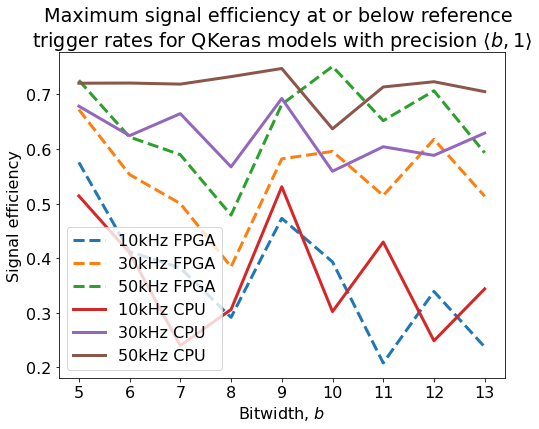

In [12]:
### Visualise the performance of the QKeras models

fig, ax = plt.subplots()
sns.lineplot(x='bitwidth', y='sens_at_spec_10kHz', data=bitwidth_scan[bitwidth_scan['device'] == 'fpga'], lw=3., ls='--', ax=ax, label='10kHz FPGA')
sns.lineplot(x='bitwidth', y='sens_at_spec_30kHz', data=bitwidth_scan[bitwidth_scan['device'] == 'fpga'], lw=3., ls='--', ax=ax, label='30kHz FPGA')
sns.lineplot(x='bitwidth', y='sens_at_spec_50kHz', data=bitwidth_scan[bitwidth_scan['device'] == 'fpga'], lw=3., ls='--', ax=ax, label='50kHz FPGA')
sns.lineplot(x='bitwidth', y='sens_at_spec_10kHz', data=bitwidth_scan[bitwidth_scan['device'] == 'cpu'], lw=3., ax=ax, label='10kHz CPU')
sns.lineplot(x='bitwidth', y='sens_at_spec_30kHz', data=bitwidth_scan[bitwidth_scan['device'] == 'cpu'], lw=3., ax=ax, label='30kHz CPU')
sns.lineplot(x='bitwidth', y='sens_at_spec_50kHz', data=bitwidth_scan[bitwidth_scan['device'] == 'cpu'], lw=3., ax=ax, label='50kHz CPU')
plt.ylabel('Signal efficiency')
plt.xlabel(r'Bitwidth, $b$')
plt.title('Maximum signal efficiency at or below reference \ntrigger rates' + r' for QKeras models with precision $\langle{b,1}\rangle$')
ax.legend()

bitwidth_scan['model_path'] = [f'{storage_area}qat_<{int(i)},1>' for i in bitwidth_scan['bitwidth'].values]
bitwidth_scan.to_csv('/usersc/bz18310/previous_notebook/results/qat_<b,1>_perf.csv')

print(bitwidth_scan[bitwidth_scan['device'] == 'fpga'])
print(bitwidth_scan[bitwidth_scan['device'] == 'cpu'])

In [13]:
### Run csynth on all the QKeras models

import re

# putting this here again in case previous sections of the notebook have not been executed
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

storage_area = '/usersc/bz18310/previous_notebook/'
for dir in os.listdir(storage_area):

    m = re.match('^qat_<(\d+),1>', dir)
    if m:

        prj_dir = os.path.join(storage_area, dir, 'hls4ml_prj')
        if not os.path.isdir(os.path.join(prj_dir,
                                          'myproject_prj', 'solution1', 'syn')):

            # load qkeras model and convert to hls
            print('Loading QKeras model from', prj_dir)
            hls_model = load_qkeras_hls_model(prj_dir)

            print('Running csynth on model...')
            hls_model.compile()
            _ = hls_model.build(reset=True)

        else:
            print('Csynth design already exists.')

Loading QKeras model from /usersc/bz18310/previous_notebook/qat_<11,1>/hls4ml_prj
Loading configuration from /usersc/bz18310/previous_notebook/qat_<11,1>/hls4ml_prj/hls4ml_config.yml
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shap

Done
Loading QKeras model from /usersc/bz18310/previous_notebook/qat_<12,1>/hls4ml_prj
Loading configuration from /usersc/bz18310/previous_notebook/qat_<12,1>/hls4ml_prj/hls4ml_config.yml
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current

In [14]:
### Now look at the resource usage post-csynth by parsing the Vivado HLS reports

from hls4ml.report import parse_vivado_report

storage_area = '/usersc/bz18310/previous_notebook'
res_data = pd.DataFrame({'BRAM_18K': [], 'DSP48E': [], 'FF': [], 'LUT': [], 'Bitwidth': []})
for dir in os.listdir(storage_area):
    m = re.match('^qat_<(\d+),1>', dir)
    if m:
        build_result = hls4ml.report.parse_vivado_report(os.path.join(storage_area, dir, 'hls4ml_prj'))
        if build_result is not None:
            res = plot_resources(None, build_result)
            res_data = res_data.append({**{t: res[res['resource'] == t]['rel_usage'].values[0]
                                         for t in res['resource'].unique()}, **{'Bitwidth': int(m[1])}},
                                        ignore_index=True)

resources = pd.melt(res_data, id_vars=['Bitwidth'], value_vars=['BRAM_18K', 'FF', 'LUT', 'DSP48E'])
resources.columns = ['Bitwidth', 'Resource', 'Rel usage (%)']
resources['Rel usage (%)'] = 100.*resources['Rel usage (%)']

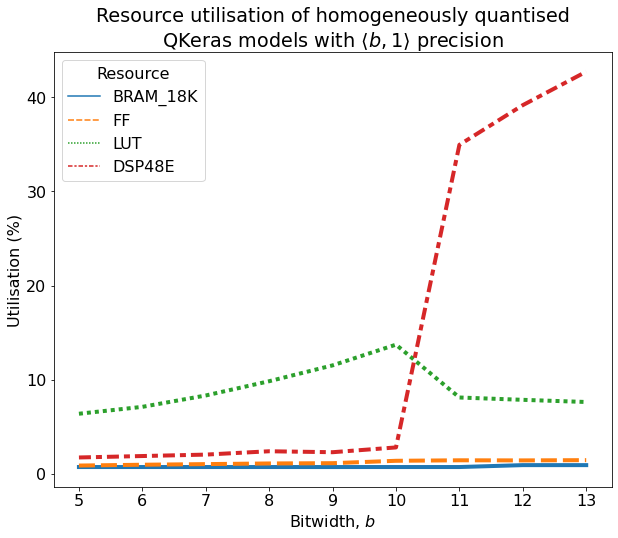

In [15]:
### Visualise the resource utilisation of the various QKeras models

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x='Bitwidth', y='Rel usage (%)', hue='Resource', data=resources, style='Resource', lw=4.)
plt.ylabel('Utilisation (%)')
plt.xlabel(r'Bitwidth, $b$')
plt.title('Resource utilisation of homogeneously quantised\n' + r'QKeras models with $\langle{b,1}\rangle$ precision')

resources.to_csv('/usersc/bz18310/previous_notebook/results/qat_<b,1>_res_csynth.csv')

In [16]:
# get timing data

storage_area = '/usersc/bz18310/previous_notebook/'
timing_data = pd.DataFrame({'Best Latency': [], 'Worst Latency': [], 'II max': [], 'II min': [], 'Bitwidth': []})
for dir in os.listdir(storage_area):
    m = re.match('^qat_<(\d+),1>', dir)
    if m:
        build_result = hls4ml.report.parse_vivado_report(os.path.join(storage_area, dir, 'hls4ml_prj'))
        if build_result is not None:
            best_lat, worst_lat, ii_min, ii_max = get_timing(build_result)
            timing_data = timing_data.append({'Best Latency': int(best_lat),
                                              'Worst Latency': int(worst_lat),
                                              'II max': int(ii_max),
                                              'II min': int(ii_min),
                                              'Bitwidth': int(m[1])},
                                        ignore_index=True)

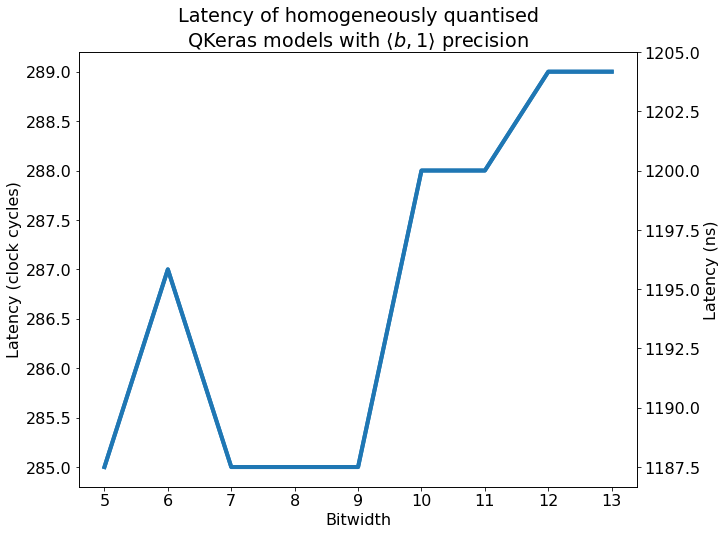

In [17]:
### Can also check the timing information post-csynth to check for abnormalities

fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(x='Bitwidth', y='Worst Latency', data=timing_data, lw=4.)
# sns.lineplot(x='Bitwidth', y='Best Latency', data=timing_data, lw=4., label='best')
ax1 = ax.twinx()
timing_data['Latency (ns)'] = timing_data['Worst Latency']*4.1666667
sns.lineplot(ax=ax1, x='Bitwidth', y='Latency (ns)', data=timing_data, lw=4.)
ax.set_ylabel('Latency (clock cycles)')
ax1.set_ylabel('Latency (ns)')
plt.xlabel(r'Bitwidth, $b$')
plt.title('Latency of homogeneously quantised\n' + r'QKeras models with $\langle{b,1}\rangle$ precision')

timing_data.to_csv('/usersc/bz18310/previous_notebook/results/qat_<b,1>_timing_csynth.csv')

Loading QKeras model from /usersc/bz18310/previous_notebook/qat_<6,1>/hls4ml_prj
Loading configuration from /usersc/bz18310/previous_notebook/qat_<6,1>/hls4ml_prj/hls4ml_config.yml
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shape:

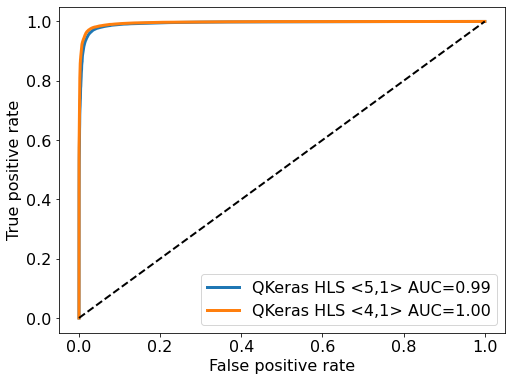

In [18]:
### The 5-bit model appears to perform best, but the 4-bit model performs well and is clearly the least resource-intensive, so let's look at both to determine which to use

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

storage_area = '/usersc/bz18310/previous_notebook/'
        
prj_dir_5 = os.path.join(storage_area, 'qat_<6,1>', 'hls4ml_prj')
print('Loading QKeras model from', prj_dir_5)

# load hls model
hls_model_5 = load_qkeras_hls_model(prj_dir_5)
hls_model_5.compile()

prj_dir_4 = os.path.join(storage_area, 'qat_<5,1>', 'hls4ml_prj')
print('Loading QKeras model from', prj_dir_4)

# load hls model
hls_model_4 = load_qkeras_hls_model(prj_dir_4)
hls_model_4.compile()

y_5 = hls_model_5.predict(test_X)
y_4 = hls_model_4.predict(test_X)

fpr_5, tpr_5, thresholds_5 = roc_curve(test_y, y_5)
fpr_4, tpr_4, thresholds_4 = roc_curve(test_y, y_4)

fig, ax = plt.subplots()
plot_roc(ax, fpr_5, tpr_5, legend=True, label='QKeras HLS <5,1>', lw=3.)
plot_roc(ax, fpr_4, tpr_4, legend=True, label='QKeras HLS <4,1>', lw=3.)
plt.plot([0,1], [0,1], ls='--', lw=2., color='black')

Calculating errors
Calculating errors


(1, 100)

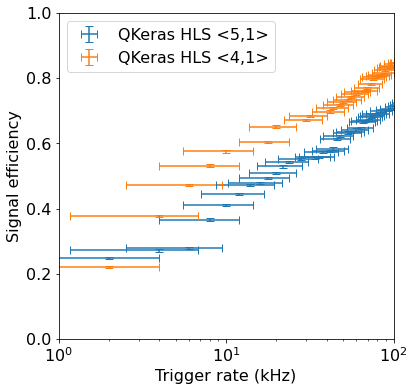

In [19]:
bg_rate = 40*10**6
rates, rates_errs, effs, effs_errs = eff_rate(fpr_5, tpr_5, thresholds_5, 
                                              bg_rate, 
                                              test_y, 
                                              y_5, errors='binomial')

effs, rates, effs_errs, rates_errs = optimal_eff_rate(effs, rates, effs_errs, rates_errs)

fig, ax = plt.subplots(figsize=(6,6))
plot_eff_rate(ax, np.array(effs), np.array(rates), 
              rates_errs=rates_errs, effs_errs=effs_errs, ls='', capsize=4., label='QKeras HLS <5,1>')

rates, rates_errs, effs, effs_errs = eff_rate(fpr_4, tpr_4, thresholds_4, 
                                              bg_rate, 
                                              test_y, 
                                              y_4, errors='binomial')

effs, rates, effs_errs, rates_errs = optimal_eff_rate(effs, rates, effs_errs, rates_errs)
plot_eff_rate(ax, np.array(effs), np.array(rates), 
              rates_errs=rates_errs, effs_errs=effs_errs, ls='', capsize=4., label='QKeras HLS <4,1>')

ax.legend()
ax.set_xscale('log')
ax.set_xlim((1,100))

In [20]:
### Combining the above graph with the fact that the $\langle{5,1}\rangle$ model uses only 1% more LUTs with other resources effectively constant, it seems that it is a no-brainer when considering the efficiency at low trigger rates.

hls_model_5.build(export=True, synth=False, vsynth=True)

{'CSimResults': [[0.00683594]],
 'EstimatedClockPeriod': '3.646',
 'BestLatency': '287',
 'WorstLatency': '287',
 'IntervalMin': '247',
 'IntervalMax': '247',
 'BRAM_18K': '14',
 'DSP48E': '37',
 'FF': '9984',
 'LUT': '37160',
 'URAM': '0',
 'AvailableBRAM_18K': '1968',
 'AvailableDSP48E': '1968',
 'AvailableFF': '1045440',
 'AvailableLUT': '522720',
 'AvailableURAM': '128'}

In [21]:
br = {'CSimResults': [[0.00292969]],
 'EstimatedClockPeriod': '3.646',
 'BestLatency': '287',
 'WorstLatency': '287',
 'IntervalMin': '246',
 'IntervalMax': '246',
 'BRAM_18K': '14',
 'DSP48E': '37',
 'FF': '9091',
 'LUT': '32731',
 'URAM': '0',
 'AvailableBRAM_18K': '1968',
 'AvailableDSP48E': '1968',
 'AvailableFF': '1045440',
 'AvailableLUT': '522720',
 'AvailableURAM': '128'}

#res = plot_resources(None, br)
#res['rel_usage'] *= 100.

### Investigation on pruning

Here we will prune the quantized models and see if we can reduce the resource usage further by itroducing sparsity.

In [22]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [23]:
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

/software/bz18310/miniconda/envs/test_python_3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
